In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-data/test/test_splitted_image/652471_0.tif
/kaggle/input/test-data/test/test_splitted_image/006388_0.tif
/kaggle/input/test-data/test/test_splitted_image/8e0244_0.tif
/kaggle/input/test-data/test/test_splitted_image/c5e687_0.tif
/kaggle/input/test-data/test/test_splitted_image/a9573c_0.tif
/kaggle/input/test-data/test/test_splitted_image/32e44f_0.tif
/kaggle/input/test-data/test/test_splitted_image/029c68_0.tif
/kaggle/input/test-data/test/test_splitted_image/d8db68_0.tif
/kaggle/input/test-data/test/test_splitted_image/a4c877_0.tif
/kaggle/input/test-data/test/test_splitted_image/283f35_0.tif
/kaggle/input/test-data/test/test_splitted_image/f4d8f8_0.tif
/kaggle/input/test-data/test/test_splitted_image/ffec5c_1.tif
/kaggle/input/test-data/test/test_splitted_image/355354_0.tif
/kaggle/input/test-data/test/test_splitted_image/d862da_0.tif
/kaggle/input/test-data/test/test_splitted_image/bd0cea_0.tif
/kaggle/input/test-data/test/test_splitted_image/658beb_0.tif
/kaggle/

In [2]:
# !ls /kaggle/input/pyvips-python-and-deb-package-gpu
# # intall the deb packages
# !yes | dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package-gpu/linux_packages/archives/*.deb
# # install the python wrapper
# !pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package-gpu/python_packages/ --no-index
# !pip list | grep pyvips

In [3]:
# !pip install openslide-python

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# import pyvips
import cv2

import random

import torch
import torch.nn as nn
from torchvision import models,transforms
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset,random_split
from PIL import Image
from pathlib import Path
from glob import glob

from collections import defaultdict
from openslide import OpenSlide

from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage.exposure import is_low_contrast
from collections import defaultdict
from skimage.io import imread
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

random.seed(19)

In [5]:
IMG_SIZE = 224
IMG_CHANNELS = 3

In [6]:
data_path ='/kaggle/input/test-data/'
test_path = data_path + 'test/test_splitted_image/'

In [7]:
test_images_mtdt = glob(test_path + "*")
print(f"Number of images in a testing set: {len(test_images_mtdt)}")

Number of images in a testing set: 20


In [8]:
def get_images_info(images_mtdt):
    img_prop = defaultdict(list)
    for i, path in enumerate(images_mtdt):
        img_path = images_mtdt[i]
        image_id = img_path[-12:-4]

        slide = OpenSlide(img_path)

        big_dim = 'none'
        max_min_dim_ratio = 1.0

        img_width = slide.dimensions[0]
        img_height = slide.dimensions[1]

        if(img_width > img_height):
            big_dim = 'width'
            max_min_dim_ratio = round(img_width/img_height, 2)
        elif(img_width < img_height):
            big_dim = 'height'
            max_min_dim_ratio = round(img_height/img_width, 2)

        img_prop['image_id'].append(image_id)
        img_prop['width'].append(img_width)
        img_prop['height'].append(img_height)
        img_prop['big_dim'].append(big_dim)
        img_prop['max_min_dim_ratio'].append(max_min_dim_ratio)
        
        split_size = round(max_min_dim_ratio)
        img_prop['split_size'].append(split_size)
        img_prop['path'].append(img_path)
        
        img_info = pd.DataFrame(img_prop)
        img_info.sort_values(by='image_id', inplace=True)
        img_info.reset_index(inplace=True, drop=True)

    return img_info

In [9]:
test_images_info = get_images_info(test_images_mtdt)
test_images_count = test_images_info['image_id'].nunique()
test_images = np.zeros((test_images_count, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

In [10]:
def get_score(img):
    imgray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

In [11]:
def process_tiles(row, last_img_index, score_dict):
    image_id = row['image_id']
    
    width = row['width']
    height = row['height']
    big_dim = row['big_dim']
    split_size = row['split_size']
    input_test_path = row['path']
#     center_id = row['center_id']
#     patient_id = row['patient_id']
#     image_num = row['image_num']

    
    n_across = 1
    n_down = 1

    if(split_size == 1):
        crop_width = width
        crop_height = height
    if(big_dim == 'width'):
        crop_width = width//split_size
        crop_height = height
        n_across = split_size
    else:
        crop_height = height//split_size
        crop_width = width
        n_down = split_size

    selected_tile = None
    max_tile_score = 0

    vips_img = pyvips.Image.new_from_file(input_test_path, access='sequential')

    for x in range(n_across):
        for y in range(n_down):
            vips_tile = None
            if(split_size > 1):
                vips_tile = vips_img.crop(x*crop_width, y*crop_height, crop_width, crop_height)
            else:
                vips_tile = vips_img
                
            vips_tile = vips_tile.thumbnail_image(IMG_SIZE, height=IMG_SIZE, size='force')
            tile_score = get_score(vips_tile)
            print('processing slice: ', (x+y) , crop_width, ' X ', crop_height, 'score', tile_score)
            
            if(tile_score > max_tile_score):
                max_tile_score = tile_score
                selected_tile = vips_tile
    
    test_image = selected_tile.numpy()
    test_images[last_img_index] = test_image
    score_dict['last_img_index'].append(last_img_index)
#     score_dict['patient_id'].append(patient_id)
    score_dict['score'].append(max_tile_score)
    last_img_index += 1
    
    vips_img = None
    return last_img_index

In [12]:
def generate_tiles():
    score_dict = defaultdict(list)
    last_img_index = 0
    #change to test_images_info
    for ind, row in test_images_info.iterrows():
#         if(ind > 280):
#             continue
        print('processing image:', row['image_id'], 'index:', str(ind + 1))
        last_img_index = process_tiles(row, last_img_index, score_dict)
        print('====================================')
    print('processed test images:', last_img_index)
    return pd.DataFrame(score_dict)

In [13]:
# score_df = generate_tiles()

In [14]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

class ResNet50Model(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=1e-7):
        super(ResNet50Model, self).__init__()

        # Load the pretrained ResNet50 model
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Modify the last fully connected layer to match the number of classes
        out_features = self.resnet50.fc.out_features
        # Additional layers
        self.dense1 = nn.Linear(out_features, 256)  # Adjust the output size
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(256, num_classes)  # Fix the number of output units
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        # Learning rate
        self.learning_rate = learning_rate

    def forward(self, x):
        # Feed data forward through the network
        x = self.resnet50(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x

    def configure_optimizers(self):
        # Use Adam optimizer and reduce learning rate on plateau to avoid overshooting
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        # Calculate loss
        loss = self.criterion(outputs, y)
        _, predictions = torch.max(outputs, 1)
        # Calculate accuracy
        acc = torch.sum(predictions == y).item() / y.size(0)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs,y)
        _, predictions = torch.max(outputs, 1)
        acc = torch.sum(predictions == y).item() / y.size(0)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

In [15]:
# from src.models.helpers import FireModule as Fire
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim

class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.squeeze_normalization = nn.BatchNorm2d(num_features= squeeze_planes)  
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand_activation = nn.ReLU(inplace=True)
        
        self.expand_normalization = nn.BatchNorm2d(num_features=expand1x1_planes + expand3x3_planes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze(x)
        x = self.squeeze_normalization(x)
        x = self.squeeze_activation(x)
        x =  torch.cat([self.expand1x1(x),self.expand3x3(x)],1)
        x = self.expand_normalization(x)
        x = self.expand_activation(x)
        
        return x
class SqueezeNet(pl.LightningModule):
    def __init__(self):
        super(SqueezeNet, self).__init__()

        self.conv0 = nn.Conv2d(3, 96, kernel_size=5, stride=2)
        self.bn0 = nn.BatchNorm2d(96)
        self.relu0 = nn.ReLU(inplace=True)
        
        self.maxpool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1,)
        
        self.fire1 =  Fire(96, 16, 64, 64)
        self.fire2 =  Fire(128, 16, 64, 64)
        self.fire3 =   Fire(128, 32, 128, 128)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2,  padding=1)
        
        self.fire4 =  Fire(256, 32, 128, 128)
        self.fire5 =  Fire(256, 48, 192, 192)
        self.fire6 =   Fire(384, 48, 192, 192)
        self.fire7 =   Fire(384, 64, 256, 256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2,  padding=1)
        self.fire8 = Fire(512, 64, 512, 512)
        self.drop = nn.Dropout(0.5)
        
        self.conv1 = nn.Conv2d(1024,2048, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(2048)
        self.relu1 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool3d(kernel_size=(1024,14, 14))
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)

        


    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.maxpool0(x)
        x = self.fire1(x)
        x = self.fire2(x)
        x = self.fire3(x)
        x = self.maxpool1(x)
        x = self.fire4(x)
        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.maxpool2(x)
        x = self.drop(x)
        x = self.fire8(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x) 
        x = self.avgpool(x)        
        x = self.flatten(x)
        x = self.softmax(x)

        
        return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss(reduction="none")(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y).item() / len(y)
        self.log("train_loss",loss.mean(),on_epoch = True,prog_bar = True, on_step = True)
        self.log("train_acc", acc,on_epoch = True,prog_bar = True, on_step = True)
        return loss.mean()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss(reduction="none")(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y).item() / len(y)
        self.log("val_loss",loss.mean(),on_epoch = True,prog_bar = True, on_step = True)
        self.log("val_acc",acc,on_epoch = True,prog_bar = True, on_step = True)
        return {"val_loss": loss.mean(),"val_acc": acc}


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        lr_scheduler = {'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3,min_lr=1e-6),
                'monitor': 'train_loss'}

        return [optimizer], [lr_scheduler]


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ResNet_model = ResNet50Model.load_from_checkpoint('/kaggle/input/resnet50-model/resnet50_train_only-loss-val_loss=0.53.ckpt')
SqueezeNet_model = SqueezeNet.load_from_checkpoint('/kaggle/input/squeeze-model/squeeze-model.ckpt')

ResNet_model.eval()
SqueezeNet_model.eval()

ResNet_model = ResNet_model.to(device)
SqueezeNet_model = SqueezeNet_model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.5MB/s]


In [17]:

test_images = np.load('/kaggle/input/test-images-numpy/test_images.npy')
# test_images = test_images/255.0
# test_images = np.transpose(test_images, (0, 3, 1, 2))
test_images_tensor = torch.tensor(test_images).float()
test_images_tensor = test_images_tensor.to(device)

In [18]:
def label_with_threshold(output,threshold):
    '''This Function takes the output from softmax and return labels according to threshold
    Parameters:
    - output : output of softmax of the model (n,2) where n is number of samples
    - threshold : threshold applied for the first probability
    Returns:
    - labels : predicted classes after applying threshold 
    '''
    labels = []
    for pred in range(len(output)):
        if output[pred][1] >= threshold:
            labels.append(1)
        else:
            labels.append(0)
    return labels
    

In [19]:
def calc_tpr_fpr(true_labels,predicted_labels):
    """
    Calculate True Positive Rate (TPR) and False Positive Rate (FPR).
    
    Parameters:
    - actual: List of actual class labels (0 or 1)
    - predicted: List of predicted class labels (0 or 1)
    
    Returns:
    - tpr: True Positive Rate
    - fpr: False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

    # Calculate TPR and FPR
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr
    

In [20]:
def weighted_log_loss_kaggle(probs, weights, target):
    """
    Calculate metric for mayo-clinic-strip-ai competition.
    
    Parameters:
    - probs : Prediction of models as two output of softmax
    - weights : Weights for each class in the metric
    - target : Actual labels
    
    Returns:
    - Competitiion Metric measure
    """
    probs = np.array(probs)
    log_probs = np.log(probs)
    weights = np.array(weights)

    target = np.array(target)
    res = 0
    for c in np.unique(target):
        class_log_probs = log_probs[target == c][:, c]
        class_weight = weights[c]
        res += class_weight * class_log_probs.mean()
    return - (res / weights.sum())

In [81]:
def plot_conf_mat(true_labels,predicted_labels,title='Confusion Matrix'):
    """ Function to calculate confusion matrix and plot it
    Parameters:
    - true_labels : Actual labels of the images
    - predicted_labels : Predicted labels of the images
    - title : title of the plot and its name
    
    Returns:
    - png image of confusion matrix
    """
    cm = confusion_matrix(predicted_labels.detach().cpu().numpy(), true_labels)
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predicted_labels.detach().cpu().numpy()), yticklabels=np.unique(true_labels),annot_kws={"size": 35})
    plt.title(f'Confusion Matrix of {title}')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.savefig(f'Confusion_Matrix_{title}.png')
    plt.show()

In [82]:
def plot_roc(prob,title='Roc Curve'):
    """ Function to calculate confusion matrix and plot it
    Parameters:
    - prob : Probability for the classes as array
    - title : title of the plot and its name
    
    Returns:
    - png image of ROC curve
    """
    thresholds = np.arange(0, 1.0, 0.001)
    tprs = []
    fprs = []
    for threshold in thresholds:
        new_labels = label_with_threshold(prob,threshold)
        tpr,fpr = calc_tpr_fpr(labels,new_labels)
        tprs.append(tpr)
        fprs.append(fpr)
    plt.plot(fprs, tprs, label='ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC of {title}')
    roc_auc = auc(fprs, tprs)
    print(f"AUC: {roc_auc:.2f}")
    plt.legend()
    plt.savefig(f'ROC_Curve_{title}.png')
    plt.show()

In [83]:
classes = ['CE','LAA']
class_to_int = {classes[i] : i for i in range(len(classes))}
df = pd.read_csv('/kaggle/input/mayo-clinic-strip-ai/train.csv')
labels = []
for i in range(len(test_images_mtdt)):
    label = df[test_images_info.iloc[i]['image_id'] == df['image_id']]['label'].iloc[0]
    labels.append(class_to_int[label])

In [84]:
output_Res = ResNet_model(test_images_tensor)
output_Res_prob = nn.Softmax(dim=1)(output_Res)
output_Res = torch.argmax(output_Res_prob, dim=1)

output_Squeeze = SqueezeNet_model(test_images_tensor)
output_Squeeze_prob = nn.Softmax(dim=1)(output_Squeeze)
output_Squeeze = torch.argmax(output_Squeeze_prob, dim=1)

output_prob = (output_Res_prob + output_Squeeze_prob)/2
output = torch.argmax(output_prob, dim=1)

In [96]:
print(f'Competition Metric  = {weighted_log_loss_kaggle(output_prob.detach().cpu().numpy(), [0.3,0.7], labels)}')

Competition Metric  = 0.6036046206951141


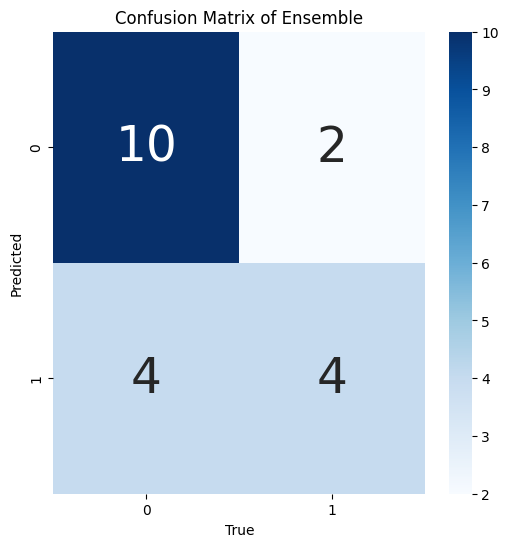

In [86]:
plot_conf_mat(labels,output,'Ensemble')

AUC: 0.75


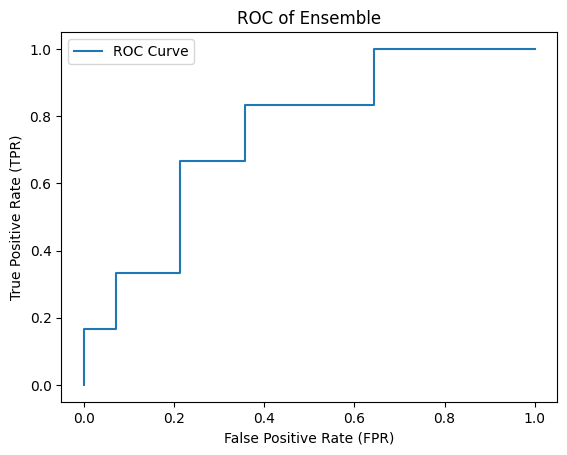

In [89]:
plot_roc(output_prob,'Ensemble')

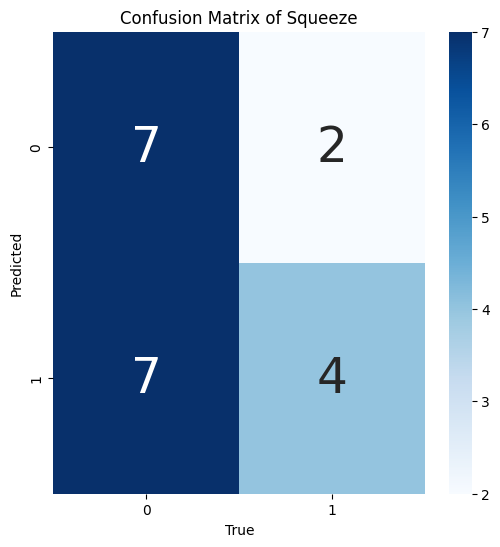

In [90]:
plot_conf_mat(labels,output_Squeeze,'Squeeze')

AUC: 0.65


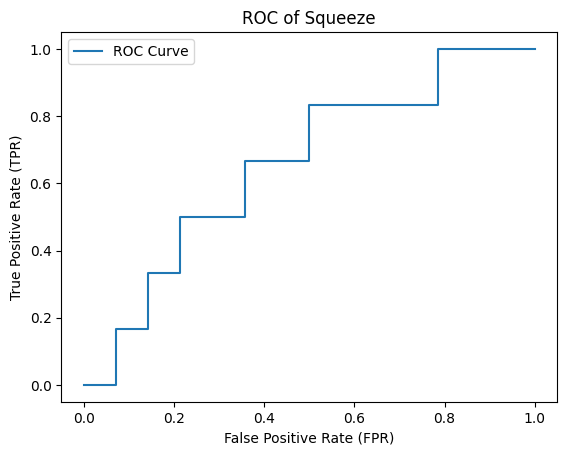

In [91]:
plot_roc(output_Squeeze_prob,'Squeeze')

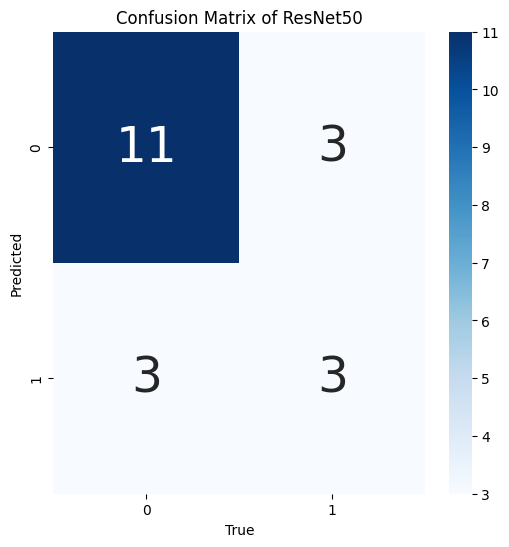

In [92]:
plot_conf_mat(labels,output_Res,'ResNet50')

AUC: 0.69


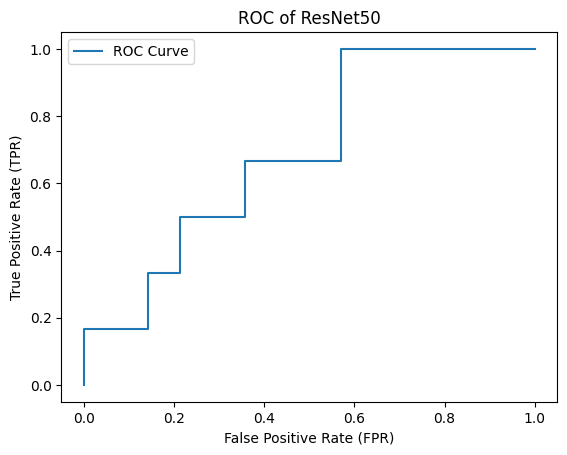

In [93]:
plot_roc(output_Res_prob,'ResNet50')

In [94]:
def calculate_metrics(y_true, y_predicted):
    # Confusion matrix
    tp = sum((true == 0 and pred == 0) for true, pred in zip(y_true, y_predicted))
    tn = sum((true == 1 and pred == 1) for true, pred in zip(y_true, y_predicted))
    fp = sum((true == 1 and pred == 0) for true, pred in zip(y_true, y_predicted))
    fn = sum((true == 0 and pred == 1) for true, pred in zip(y_true, y_predicted))

    # Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    # Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    return precision, recall, f1, accuracy, specificity
# Calculate metrics
precision, recall, f1, accuracy, specificity = calculate_metrics(labels, output)

# Print the results
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1.numpy())
print("Accuracy:", accuracy.numpy())
print("Specificity:", specificity.numpy())


Precision: 0.8333333
Recall: 0.71428573
F1 Score: 0.7692307
Accuracy: 0.7
Specificity: 0.6666667
